# Mini Project2


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [14]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [15]:
def grad_U(Ui, Yij, Vj, reg, eta, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    grad = reg*Ui - Vj * ((Yij-mu) - np.dot(Ui,Vj))

    foo = eta*grad

    return foo
        

def grad_V(Vj, Yij, Ui, reg, eta, mu):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg*Vj - Ui * ((Yij-mu) - np.dot(Ui,Vj))

    foo = eta*grad

    return foo

def get_err(U, V, Y, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """

    N = Y.shape[0]
    err = 0
    for i in range(N):
        Y_idx = Y[i]
        Ui  = U[Y_idx[0]-1,:]
        Vj  = V[Y_idx[1]-1,:]
        Yij = Y_idx[2]

        err += ((Yij-mu) - np.dot(Ui,Vj))**2

    err = err/(2*N)
    err = err + (reg/2)*(np.linalg.norm(U, ord='fro') + np.linalg.norm(V, ord='fro')) 

    return err


def train_model(M, N, K, eta, reg, Y, mu, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    U = np.random.uniform(-0.5,0.5,size=(M,K)) 
    V = np.random.uniform(-0.5,0.5,size=(N,K))

    err_0 = get_err(U, V, Y, mu, reg=reg) 

    N_y = Y.shape[0]
    
    for c in range(max_epochs):
        j = np.random.permutation(np.array(range(N_y)))
        for i in j:
            Y_idx  = Y[i]
            Ui  = U[Y_idx[0]-1,:]
            Vj  = V[Y_idx[1]-1,:]
            Yij = Y_idx[2]

            Ui = Ui - grad_U(Ui,Yij,Vj, reg, eta, mu)
            Vj  = Vj - grad_V(Vj,Yij,Ui, reg, eta, mu)
        
            U[Y_idx[0]-1,:] = Ui
            V[Y_idx[1]-1,:] = Vj

        err = get_err(U, V, Y, mu, reg=reg)

        if c == 0:
            err_int = np.abs(err-err_0)
            err_1 = 0
        
        err_ratio = (err_1-err)/err_int

        if (err_ratio < eps) and (err_ratio > 0):
            err = get_err(U, V, Y, mu)
            break
        
        err_1 = err

    return U, V, err

In [16]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

N = train.shape[0]
mu = 0
for i in range(N):
    Y_idx = train[i]
    Yij   = Y_idx[2]
    mu += Yij
mu_train = mu/N

Factorizing with  943  users,  1682  movies.
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.01
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.012742749857031334
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.016237767391887217
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.0206913808111479
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.026366508987303583
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.03359818286283781
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.04281332398719394
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.0545559478116852
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.06951927961775606
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.08858667904100823
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.11288378916846889
Training model with M = 943, N = 1

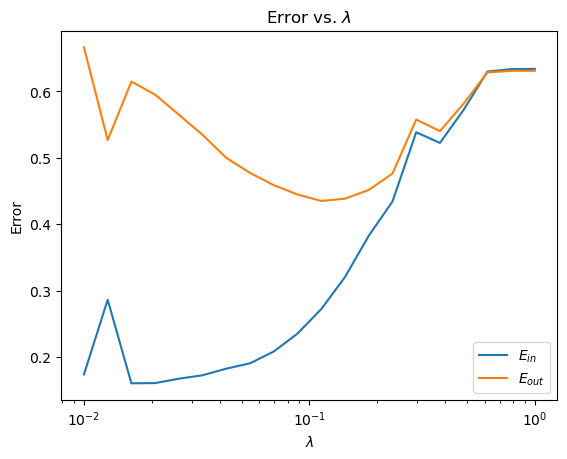

In [17]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

regs = np.logspace(-2,0,20)
eta = 0.05
# etas = np.linspace(0.01,0.1,10)
E_in = []
E_out = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V, err = train_model(M, N, K, eta, reg, train, mu_train, eps=0.005)
    E_in.append(err)
    E_out.append(get_err(U, V, test, mu_train))

plt.semilogx(regs, E_in, label='$E_{in}$')
plt.semilogx(regs, E_out, label='$E_{out}$')
plt.title('Error vs. $\lambda$')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('set5_test_reg_smaller.png')